label
0.0     929661
4.0     238761
17.0    238690
1.0     192523
3.0     189931
7.0     188107
2.0     185188
16.0    175353
6.0     164600
12.0    117216
13.0    104944
5.0      98199
24.0     49360
Name: count, dtype: int64


<Axes: >

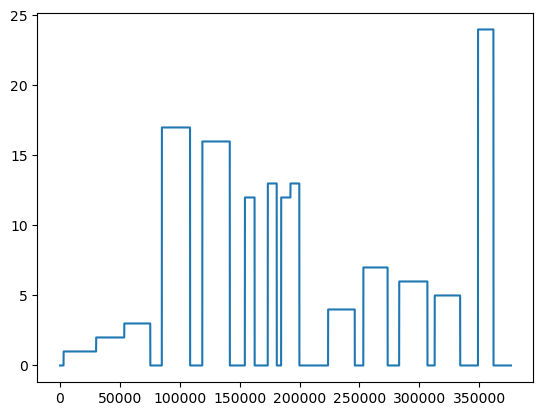

In [1]:
import os
import pandas as pd
import numpy as np

dataset_root = './data/pamap2_dataset/Protocol'

dataset_dfs = list()

for fn in os.listdir(dataset_root):
    with open(os.path.join(dataset_root, fn)) as f:
        data = f.readlines()

    data = list(map(lambda x: x.strip().split(), data))
    data = list(map(lambda l: list(map(float, l)), data))

    data_df = pd.DataFrame(data, columns=['timestamp', 'label']+[f'feature_{i}' for i in range(len(data[0]) - 2)])
    data_df['subject'] = fn.split('.')[0]

    dataset_dfs.append(data_df)

print(pd.concat(dataset_dfs).label.value_counts())
data_df.label.plot()

In [2]:
def slice_df_by_label_changepoints(df):
    changepoint_indices = np.where(df.label[:-1].to_numpy() - df.label[1:].to_numpy())[0] + 1
    slices = list()

    left = 0

    for idx in changepoint_indices:
        slices.append(df.iloc[left: idx])
        left = idx

    slices.append(df.iloc[left:])

    return slices


def merge_slices_by_label(slices):
    grouped_slices = dict()
    for s in slices:
        slice_label = s.iloc[0].label
        if slice_label not in grouped_slices:
            grouped_slices[slice_label] = [s]
        else:
            grouped_slices[slice_label].append(s)

    return [pd.concat(group) for group in list(grouped_slices.values())]


dataset_slices = list()

for df in dataset_dfs:
    slices = slice_df_by_label_changepoints(df)
    slices = merge_slices_by_label(slices)

    dataset_slices.extend(slices)

dataset_slices = merge_slices_by_label(dataset_slices)
assert all([s.label.nunique() == 1 for s in dataset_slices])

# 0th class has to be downsampled, others are ok
downsampling_number = sorted([s.shape[0] for s in dataset_slices])[-2]
zero_class_slice_idx = [s.iloc[0].label for s in dataset_slices].index(0)

dataset_slices[zero_class_slice_idx] = dataset_slices[zero_class_slice_idx].groupby('subject').head(int(downsampling_number / dataset_slices[zero_class_slice_idx].subject.nunique()))

dataset_df = pd.concat(dataset_slices)
dataset_df = dataset_df.loc[pd.notna(dataset_df).all(axis=1)]
labels = dataset_df.label
dataset_df = dataset_df.drop(columns=['label', 'subject', 'feature_0'])

assert labels.nunique() == 13
assert dataset_df.shape[0] == labels.shape[0]

In [3]:
dataset_df.shape

(194968, 52)